# __Neural Networks__
## Exam Project: Adversarial Training for Free!

**Students**:
- **Name**: *Gianmarco Scarano* | Matricola Code: *2047315*<br>
- **Name**: *Giancarlo Tedesco* | Matricola Code: *2057231*

### Google Colab compatibility
Run this next cell only if you're using Google Colab!

In [ ]:
# Library needed for this notebook
!pip install -U tqdm --quiet

# Imports

In [1]:
# We set the global variable for Google Colab, so we can assign possible paths, etc. accordingly
try:
  import google.colab
  RunningInCOLAB = True
except:
  RunningInCOLAB = False

In [37]:
import random
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

print('Dependecies correctly loaded.')

Dependecies correctly loaded.


## Check if we have CUDA support

In [3]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print('Cuda available: {}'.format(torch.cuda.is_available()))
    print("GPU: " + torch.cuda.get_device_name(torch.cuda.current_device()))
    print("Total memory: {:.1f} GB".format((float(torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)))))
    print("===================================================")
else:
    device = torch.device("cpu")
    print('Cuda not available, so using CPU. Please consider switching to a GPU runtime before running the notebook!')

Cuda available: True
GPU: NVIDIA GeForce RTX 3060
Total memory: 12.0 GB


# Fashion MNIST Dataset

In [4]:
# Data augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [5]:
# Download the train dataset
train_dataset = datasets.FashionMNIST(root ='./', train=True, download=True, transform=transform)

# Download the test dataset
test_dataset = datasets.FashionMNIST(root ='./', train=False, download=True, transform=transform)

# Create train and test data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

c:\Users\Gianmarco\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
# Input size of the image divided into 4 variables
in_channels, height, width = train_dataset[0][0].size()
print(F"Width: {width}")
print(F"Height: {height}")
print(F"Channels: {in_channels}")
print("-----------------------------")
# Class names
print(F"Class names: {train_dataset.classes}")
print(F"Number of classes: {len(train_dataset.classes)}")
print("-----------------------------")
# Number of samples for training / validation set
print(F"Number of samples for training set: {len(train_dataset)}")
print(F"Number of samples for validation set: {len(test_dataset)}")

Width: 28
Height: 28
Channels: 1
-----------------------------
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Number of classes: 10
-----------------------------
Number of samples for training set: 60000
Number of samples for validation set: 10000


# Model definition: DummyNet

In [7]:
class DummyNet(nn.Module):
    def __init__(self, num_classes=10):
        super(DummyNet, self).__init__()

        # First convolution
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, device=device)
        self.bn1 = nn.BatchNorm2d(32, device=device)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolution
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, device=device)
        self.bn2 = nn.BatchNorm2d(64, device=device)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third convolution
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1, device=device)
        self.bn3 = nn.BatchNorm2d(32, device=device)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Activation functions
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(288, 150, device=device) # 288 is the output shape of the Flatten() function applied after the 3rd convolutional block.
        self.fc2 = nn.Linear(150, 50, device=device)
        self.fc3 = nn.Linear(50, num_classes, device=device)

    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x)))) # First convolution
        x = self.pool2(self.relu(self.bn2(self.conv2(x)))) # Second convolution
        x = self.pool3(self.relu(self.bn3(self.conv3(x)))) # Third convolution

        x = self.flatten(x) # Flatten of the output of the 3rd convolutional block

        x = self.relu(self.fc1(x))  # FC1
        x = self.relu(self.fc2(x))  # FC2

        x = self.fc3(x)             # Output layer
        return self.softmax(x)      # Final activation function (SoftMax)

# Training phase

## Training parameters

In [33]:
# Let's define some variables for the training phase
lr = 1e-3
momentum = 0.9
epochs = 20

# Our model
model = DummyNet(num_classes=10)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

## FreeAdversarial parameters

In [34]:
m = 4 # Usually it's a value m ≤ 10
epochs = int(epochs / m)
epsilon = 0.1
delta = torch.zeros([32, in_channels, width, height], device=device)
batchNoise = None

mean = torch.Tensor(np.array([0.1307])[:, np.newaxis, np.newaxis])
mean = mean.expand(in_channels, width, height).cuda()
std = torch.Tensor(np.array([0.3081])[:, np.newaxis, np.newaxis])
std = std.expand(in_channels, width, height).cuda()

## Actual training phase (Normal + FreeAdv)

In [35]:
# Train the model
for epoch in range(epochs): # 3: for epoch = 1 . . . Nep/m do

    correct = 0
    correctVal = 0
    totalLab = 0
    total = 0

    model.train()
    
    for i, (images, labels) in enumerate(tqdm(train_loader, desc=F"Epoch n.{epoch+1} (Train)")): # 4: for minibatch B ⊂ X do

        # We need to move to the GPU otherwise PyTorch will give issues when adding noise_batch to images
        images = images.to(device=device)
        labels = labels.to(device=device)
        
        for j in range(m): # 5: for i = 1 . . . m do

            # We want our model to not be trained on simple images but on images with noise δ (delta)
            batchNoise = delta[0:images.size(0)]
            batchNoise.to(device=device).requires_grad_(True)

            editedInput = images.clone()
            editedInput.add_(batchNoise)
            editedInput.clamp_(-1, 1)

            # Forward pass
            outputs = model(editedInput)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward(retain_graph=True) # 7: gθ ← E(x,y)∈B[∇θ l(x + δ, y, θ)] + 9: θ ← θ − τgθ ----> Plus we go popolate the noise_batch.grad value

            gadv = batchNoise.grad # 8: gadv ← ∇x l(x + δ, y, θ)] ---> We already computed this, we are just storing it in a variable

            # Update the noise for the next iteration
            delta = delta + (epsilon * torch.sign(gadv)) # 11: δ ← δ + eps · sign(gadv)
            
            delta = torch.clamp_(delta, - epsilon, epsilon) # 12: δ ← clip(δ, -eps, eps)

            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            totalLab += labels.size(0)

    accuracy = correct / totalLab

    # Test the model
    model.eval()

    with torch.no_grad():

        for valImg, labels in tqdm(test_loader, desc=F"Epoch n.{epoch+1} (Validation)"):
            
            valImg = valImg.to(device=device)
            labels = labels.to(device=device)
            
            outputs = model(valImg)

            lossVal = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correctVal += (predicted == labels).sum().item()

        accuracyVal = correctVal / total

    print(f'Epoch {epoch+1:03}:')     
    print(f'\t- Training accuracy   : {accuracy:.4f}')
    print(f'\t- Training loss       : {loss.item():.4f}')
    print(f'\t- Validation accuracy : {accuracyVal:.4f}')
    print(f'\t- Validation loss : {lossVal.item():.4f}')
    print("=========================================")

Epoch n.1 (Validation): 100%|██████████| 313/313 [00:01<00:00, 192.95it/s]


Epoch 001:
	- Training accuracy   : 0.6422
	- Training loss       : 1.8163
	- Validation accuracy : 0.7733
	- Validation loss : 1.6374


Epoch n.2 (Validation): 100%|██████████| 313/313 [00:01<00:00, 176.31it/s]


Epoch 002:
	- Training accuracy   : 0.7766
	- Training loss       : 1.6982
	- Validation accuracy : 0.7683
	- Validation loss : 1.6418


Epoch n.3 (Validation): 100%|██████████| 313/313 [00:01<00:00, 182.37it/s]


Epoch 003:
	- Training accuracy   : 0.7890
	- Training loss       : 1.7186
	- Validation accuracy : 0.7803
	- Validation loss : 1.6090


Epoch n.4 (Validation): 100%|██████████| 313/313 [00:01<00:00, 191.10it/s]


Epoch 004:
	- Training accuracy   : 0.7958
	- Training loss       : 1.6436
	- Validation accuracy : 0.7734
	- Validation loss : 1.6478


Epoch n.5 (Validation): 100%|██████████| 313/313 [00:01<00:00, 174.18it/s]

Epoch 005:
	- Training accuracy   : 0.8017
	- Training loss       : 1.6582
	- Validation accuracy : 0.7676
	- Validation loss : 1.6286


<Figure size 432x288 with 0 Axes>

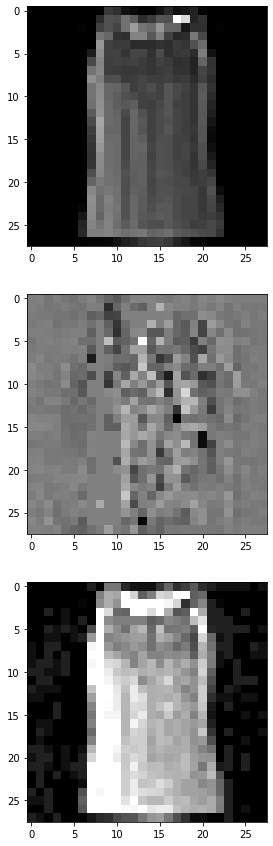

In [48]:
idx = random.randint(0, 31)

# Original
orig = np.array(images[idx].detach().cpu(), dtype='float').reshape(28,28,1)
# Adv
adv = np.array(gadv[idx].detach().cpu(), dtype='float').reshape(28,28,1)
# Edited
orig_adv = np.array(editedInput[idx].detach().cpu(), dtype='float').reshape(28,28,1)

plt.figure()
fig, axs = plt.subplots(3, 1, figsize=(15, 15))

axs[0].imshow(orig, cmap='gray')
axs[1].imshow(adv, cmap='gray')
axs[2].imshow(orig_adv, cmap='gray')

plt.show()